In [258]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from random import sample
import math
import pickle as pk
from collections import Counter
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from random import sample
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc

In [259]:
from nltk.stem.snowball import SnowballStemmer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

### topic agnostic cv exp func

In [260]:
# load topic map
topic_map_path = '../data/topic_map/pos_topic_domain_map.pkl'
topic_map = pk.load(open(topic_map_path, 'rb'))

In [261]:
def feat_label(df):
    feat = df.drop(['domain', 'label'], axis=1)
    return feat.values, df.label.values

def tp_cv_perform(df, topic_map, clf, fp_res, repeat_n):
    tprs = []
#     threshs = []
    mean_fpr = np.linspace(0, 1, 200)
    dom_list_pos = df[df.label==1]['domain'].tolist()
    dom_list_neg = df[df.label==0]['domain'].tolist()
    
    print('topic cv start')
    for t in topic_map.keys():
        dom_test_pos = topic_map[t]
        n_test_pos = len(dom_test_pos)

        dom_train_pos = set(dom_list_pos) - set(dom_test_pos)
        n_train_pos = len(dom_train_pos)

        y_test_list = []
        y_pre_list = []
        for i in range(repeat_n):
            dom_test_neg = sample(dom_list_neg, n_test_pos)
            dom_train_neg = sample(set(dom_list_neg) - set(dom_test_neg), n_train_pos*2)

            dom_train = set(dom_train_pos) | set(dom_train_neg)
            dom_test = set(dom_test_pos) | set(dom_test_neg)

            df_train = df[df['domain'].isin(dom_train)]
            df_test = df[df['domain'].isin(dom_test)]

            feature_train, label_train = feat_label(df_train)
            feature_test, label_test = feat_label(df_test)
            
            model = clf.fit(feature_train, label_train)

            y_pre_prob = model.predict_proba(feature_test)[:,1]

            y_test_list.append(label_test)
            y_pre_list.append(y_pre_prob)

        y_test_array = np.concatenate(y_test_list)
        y_pre_array = np.concatenate(y_pre_list)
        
        fpr_t, tpr_t, thresh_t = metrics.roc_curve(y_test_array, y_pre_array)
        interp_tpr = np.interp(mean_fpr, fpr_t, tpr_t)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    mean_fpr_100 = mean_fpr * 100
    mean_tpr_100 = mean_tpr * 100

    i_1, = np.where(mean_fpr_100>=1.0)
    y_1 = round(mean_tpr_100[i_1[0]])
    
    res_dict = {
                "mean_fpr_100": mean_fpr_100,
                "mean_tpr_100": mean_tpr_100,
                "mean_auc": mean_auc,
                "i_1": i_1,
                "y_1": y_1
                }

    with open(fp_res, 'wb') as f:
        pk.dump(res_dict, f)
    
    return mean_auc, y_1

### tp agnotic cross validation exp with taser

In [262]:
def taser_topic_agnotic_cv(df, f_res, max_depth_x=1, n_estimators = 500, repeat_n = 3):
    max_depth = int(df.shape[1] * max_depth_x)
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123)

    return tp_cv_perform(df, topic_map, clf, f_res, repeat_n)

In [267]:
# load features to use
feature_path = '../data/feature'
featset_dict = {'pnp': 'pnp_feature.txt', 
                'bk': 'bk_feature.txt',
                'wh': 'wh_feature.txt'}

feat_list = ['domain', 'label']
for k,f in featset_dict.items():
    fp_feature_name = os.path.join(feature_path, f)
    with open(fp_feature_name, 'r') as fr:
        feature_names = [line.strip() for line in fr if not line.startswith("#")]
    feat_list += feature_names
    print(f"load {len(feature_names)} features")

load 25 features
load 30 features
load 6 features


In [268]:
# load dataset
f_tr = '../data/TSS_TA_training_data.csv'
df = pd.read_csv(f_tr, usecols=feat_list)
df.shape

(1500, 59)

In [269]:
f_res = '../temp/exp_res_pkl/taser_topic_agnostic_cv_result.pkl'

In [270]:
taser_topic_agnotic_cv(df, f_res)

topic cv start


(0.9921073079460042, 91)

### tp agnotic cross validation exp with text model

In [251]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]

    stem_doc = " ".join(stems)
    return stem_doc

In [252]:
def text_model_topic_agnotic_cv(df, f_res, repeat_n = 3):
    # Initialise the count vectorizer with the English stop words
    count_vectorizer = CountVectorizer(stop_words='english', 
                                       max_df=0.8, 
                                       max_features=10000,
                                       min_df=0.08,
                                       ngram_range=(1,3))
    
    # Fit and transform the processed titles
    count_data = count_vectorizer.fit_transform(df['text_processed'])
    df_ct = pd.DataFrame(data=count_data.toarray(), columns=[n for n in range(count_data.shape[1])])
    df_ct['domain'] = df['domain']
    df_ct['label'] = df['label']

    clf = MultinomialNB()
    return tp_cv_perform(df_ct, topic_map, clf, f_res, repeat_n)

In [253]:
# load text data
f_tr_txt = '../data/text_data_for_TSS_TA_training_set.csv'
df_txt = pd.read_csv(f_tr_txt)
df_txt.shape

(1500, 3)

In [254]:
f_res_txt = '../temp/exp_res_pkl/text_model_topic_agnostic_cv_result.pkl'
text_model_topic_agnotic_cv(df_txt, f_res_txt, repeat_n=3)

topic cv start


(0.961364738895211, 52)

### ROC curve plot

In [248]:
def roc_plot(result_path, f_res_list, y_lim):
    res = []
    for f in f_res_list:
        fp = os.path.join(result_path, f[0])
        res.append(pk.load(open(fp, 'rb')))

    fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.set_xlabel('False Positive Rate (%,log scale)', fontsize=15, weight='bold')
    ax.set_ylabel('True Positive Rate (%)', fontsize=15, weight='bold')
    ax.set(xlim=[0, 100], ylim=y_lim)
    
    for i in range(len(res)):
        ax.plot(res[i]['mean_fpr_100'], 
                res[i]['mean_tpr_100'], 
                color=f_res_list[i][2], 
                label=f"Leave {f_res_list[i][1]} Out (AUC:{round(res[i]['mean_auc']*100,2)}%)", lw=2)
    
    ax.set_xscale('symlog')
    ax.set_xticks([0, 1, 10, 100], minor=False)
    ax.set_xticklabels(['0', '1', '10', '100'], minor=False)
    y_ticks = [y for y in range(y_lim[0], y_lim[1], 10)]
    y_tick_labels = [str(y) for y in range(y_lim[0], y_lim[1], 10)]
    ax.set_yticks(y_ticks, minor=False)
    ax.set_yticklabels(y_tick_labels, minor=True)
    
    ax.legend(loc="best", fontsize='large')

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


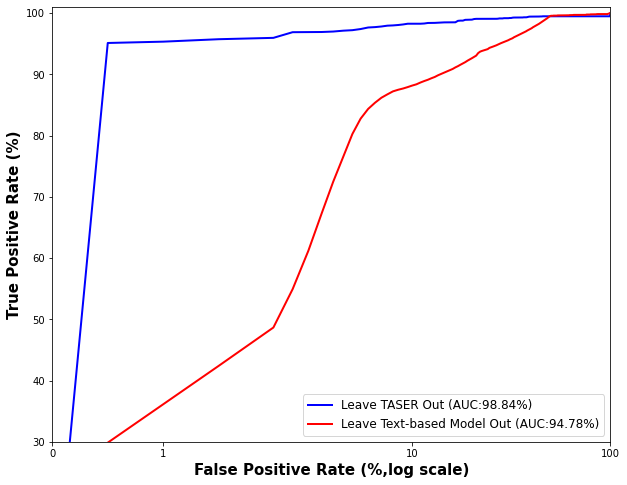

In [271]:
result_path = '../result'
f_res_list = [['topic_cv_result_taser.pkl', 'TASER', 'blue'], 
              ['topic_cv_result_text_model.pkl', 'Text-based Model', 'red']]
roc_plot(result_path, f_res_list, [30, 101])

/Users/liujienan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


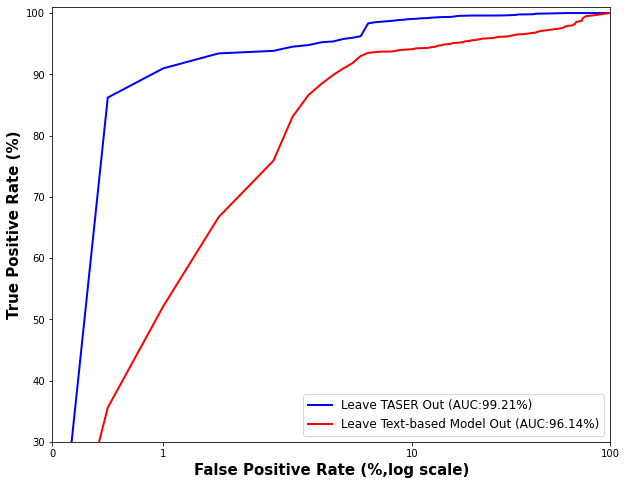

In [272]:
result_path = '../temp/exp_res_pkl'
f_res_list = [['taser_topic_agnostic_cv_result.pkl', 'TASER', 'blue'], 
              ['text_model_topic_agnostic_cv_result.pkl', 'Text-based Model', 'red']]
roc_plot(result_path, f_res_list, [30, 101])